<a href="https://colab.research.google.com/github/dunliangyang2010/Deep-Learning-practice/blob/master/BERT3_title_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title Generation
ref：https://kexue.fm/archives/6933

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install chinese-converter # convert simplified chinese to traditional
!pip install bert4keras==0.7.4

In [ ]:
!pip install keras==2.1.6

In [ ]:
import pandas as pd
import chinese_converter

In [ ]:
import pandas as pd
import glob
import numpy as np
import os

import tensorflow as tf
from bert4keras.backend import keras, K
from bert4keras.layers import Loss
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, open
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder
from keras.models import Model, load_model

Using TensorFlow backend.


AttributeError: ignored

In [ ]:
# 基本参数
maxlen = 256
batch_size = 16
steps_per_epoch = 50
epochs = 10000
FOLDER_PATH = '/content/drive/My Drive/class/勞動部/week12/BERT'
BERT_MODEL_PATH = os.path.join(FOLDER_PATH, 'chinese_L-12_H-768_A-12')

In [ ]:
# bert配置
config_path = os.path.join(BERT_MODEL_PATH, 'bert_config.json')
checkpoint_path = os.path.join(BERT_MODEL_PATH, 'bert_model.ckpt')
dict_path = os.path.join(BERT_MODEL_PATH, 'vocab.txt')

In [ ]:
df = pd.read_csv(os.path.join(FOLDER_PATH, 'sample-chinese.csv'), header=None)

# 載入精簡詞表，建立分詞器
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

In [ ]:
df

,0,1
0,對賭協議的18個致命陷阱,很多創業者對對賭協議談虎色變，代價往往讓人又愛又恨。作為舶來品，對賭引進中國後，卻已然變味，...
1,葉檀：地產是經濟發展的象徵房產稅難讓人信服,房產稅構成呼之欲出，若不清理稅費，不同步建立公共財政體制，顯然難讓人信服。筆者支持徵收房產稅...
2,沃爾瑪低頭認錯:召回賣場所賣相關商品給予補償,所售驢肉製品被檢測出是狐狸肉的零售巨頭沃爾瑪終於肯低頭認錯了。在2013年的最後一天，沃爾瑪...
3,樓繼偉：明年將擴大部門預決算公開範圍,中國正努力讓財政的錢花得更透明。財政部長樓繼偉在北京表示，2014年，要擴大部門預決算公開範...
4,未來黃金投資怎麼玩,市場人士預言，2014年將有多重利好推動金價王者歸來。不過，許多國際機構及黃金專家對今年的黃...
5,新能源汽車成政策寵兒基金加大配置力度,近日新能源汽車行業利好頻傳。據金牛理財網統計，一季度布局新能源汽車概念股的主動偏股型基金多達...
6,從國富基金到紐銀西部：誰逼走了管理團隊,“這兩公司均是中外股東內耗導致公司經營受到巨大影響的負面案例，他們遇到的很多問題都有必然性，...
7,新《環保法》元旦起實施企業違法可拘留責任人,正式實施的新《環保法》對企業懲治力度大大加強，受到罰款處罰，被責令改正，拒不改正的，依法作出...
8,今年藥品定價機制將出明年全面推公立醫院改革,據了解，公立醫院層面的改革分為兩個層面：縣級公立醫院和城市公立醫院改革。據梁萬年透露，201...
9,多名高管被調查神華反腐“不會草草收場”,12月22日，神華宣布免去集團總經理助理張文江，神華寧煤監局主任師劉寶龍二人的職位，翌日，神...


In [ ]:
def data_generator(df, batch_size):
    '''data generator for fit_generator'''
    n = len(df)
    i = 0
    df = df
    while True:
        batch_token_ids, batch_segment_ids = [], []
        for b in range(batch_size):
            if i==0:
                df = df.sample(frac=1).reset_index(drop=True)
            title = df.iloc[i, 0]
            content = df.iloc[i, 1]
            token_ids, segment_ids = tokenizer.encode(
                content, title, max_length=maxlen
            )
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            
            i = (i+1) % n
            
        batch_token_ids = sequence_padding(batch_token_ids)
        batch_segment_ids = sequence_padding(batch_segment_ids)
        yield [batch_token_ids, batch_segment_ids], None


In [ ]:
train_generator = data_generator(df, batch_size=1)
next(train_generator)

([array([[   2, 2690, 1443, 7612, 5387, 6080, 1399, 6056, 3494, 3845, 1037,
          3119, 4214, 4227, 5387, 4536, 7337, 1443, 2240, 7429, 3651, 4171,
          4352, 5071, 3074, 5405,  754, 7429, 6189, 6995,  647,  409, 1660,
          8035, 2297, 4536, 3195, 2425,  569, 1819, 7922, 3651, 4171, 4352,
          2044, 2255, 1272, 1624, 3987, 1196, 6444, 1740, 2690, 1443, 4536,
          4583, 7200, 1453, 1399, 7922,  597, 2722, 6228, 2098, 2103, 6452,
          6423, 6780, 6181, 4394, 1399, 4536, 7445, 2043, 5081,  648, 6069,
           928,  409, 3651, 4171, 4352, 2098, 2103, 3578, 6048, 1231,  917,
          8005,   17,   28,  937, 4536, 1453, 1399, 7922, 6069,  928, 7445,
          2043, 8042,  937,  409,    3, 3651, 4171, 4352,  754, 7429, 6189,
          6995,   29, 1272, 1624, 6444, 1740, 2690, 6444, 4583, 7200, 1453,
          1399, 5081,  648, 6069,  928,    3]]),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
class CrossEntropy(Loss):
    """ mask掉输入部分
    """
    def compute_loss(self, inputs, mask=None):
        y_true, y_mask, y_pred = inputs
        y_true = y_true[:, 1:]  # 目標 token_ids
        y_mask = y_mask[:, 1:]  # segment_ids，指示了要預測的部分
        y_pred = y_pred[:, :-1]  # 預測序列，錯開一位
        loss = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss = K.sum(loss * y_mask) / K.sum(y_mask)
        return loss


model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='unilm',
    keep_tokens=keep_tokens,  # 只保留keep_tokens中的字，精簡原字表
)

output = CrossEntropy(2)(model.inputs + model.outputs)

model = Model(model.inputs, output)
model.compile(optimizer=Adam(1e-5))


class AutoTitle(AutoRegressiveDecoder):
    """seq2seq decoder
    """
    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        token_ids, segment_ids = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        return model.predict([token_ids, segment_ids])[:, -1]

    def generate(self, text, topk=1):
        max_c_len = maxlen - self.maxlen
        token_ids, segment_ids = tokenizer.encode(text, max_length=max_c_len)
        output_ids = self.beam_search([token_ids, segment_ids],
                                      topk)  # 基於 beam search
        return tokenizer.decode(output_ids)


autotitle = AutoTitle(start_id=None, end_id=tokenizer._token_end_id, maxlen=32)


def just_show():
    s1 = u'夏天來臨，皮膚在強烈紫外線的照射下，曬傷不可避免，因此，曬後及時修覆顯得尤為重要，否則可能會造成長期傷害。專家表示，選擇曬後護膚品要慎重，蘆薈凝膠是最安全，有效的一種選擇，曬傷嚴重者，還請及時就醫。'
    s2 = u'8月28日，網絡爆料稱，華住集團旗下連鎖酒店用戶數據疑似发生泄露。從賣家发布的內容看，數據包含華住旗下漢庭、禧玥、桔子、宜必思等10余個品牌酒店的住客信息。泄露的信息包括華住官網注冊資料、酒店入住登記的身份信息及酒店開房記錄，住客姓名、手機號、郵箱、身份證號、登錄賬號密碼等。賣家對這個約5億條數據打包出售。第三方安全平台威脅獵人對信息出售者提供的三萬條數據進行驗證，認為數據真實性非常高。當天下午 ，華 住集 團发聲明稱，已在內部迅速開展核查，並第一時間報警。當晚，上海警方消息稱，接到華住集團報案，警方已經介入調查。'
    s3 = u'很多創業者對對賭協議談虎色變，代價往往讓人又愛又恨。作為舶來品，對賭引進中國後，卻已然變味，企業方處於相對弱勢地位，簽訂“不平等條約”。越來越多對簿公堂的事件發生。所以你一定要擦亮眼睛，否則一不小心就將陷入萬劫不復的深淵。'
    for s in [s1, s2, s3]:
        print('input: ', s)
        print(u'生成標題:', autotitle.generate(s), '\n')


class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.lowest = 1e10

    def on_epoch_end(self, epoch, logs=None):
        # 保存最好模型參數
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            model.save_weights('./title.weights')
        # 演示效果
        just_show()

In [ ]:
evaluator = Evaluate()
train_generator = data_generator(df, batch_size=8)

model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[evaluator]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


50/50 [==============================] - ETA: 0s - loss: 4.4031input:  夏天來臨，皮膚在強烈紫外線的照射下，曬傷不可避免，因此，曬後及時修覆顯得尤為重要，否則可能會造成長期傷害。專家表示，選擇曬後護膚品要慎重，蘆薈凝膠是最安全，有效的一種選擇，曬傷嚴重者，還請及時就醫。
生成標題: 膚膚膚護護護護護護護護膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚膚 

input:  8月28日，網絡爆料稱，華住集團旗下連鎖酒店用戶數據疑似发生泄露。從賣家发布的內容看，數據包含華住旗下漢庭、禧玥、桔子、宜必思等10余個品牌酒店的住客信息。泄露的信息包括華住官網注冊資料、酒店入住登記的身份信息及酒店開房記錄，住客姓名、手機號、郵箱、身份證號、登錄賬號密碼等。賣家對這個約5億條數據打包出售。第三方安全平台威脅獵人對信息出售者提供的三萬條數據進行驗證，認為數據真實性非常高。當天下午 ，華 住集 團发聲明稱，已在內部迅速開展核查，並第一時間報警。當晚，上海警方消息稱，接到華住集團報案，警方已經介入調查。
生成標題: 全國國13 13開店店酒酒店店賣賣賣賣賣賣賣賣賣賣賣賣賣賣賣賣賣賣賣賣 

input:  很多創業者對對賭協議談虎色變，代價往往讓人又愛又恨。作為舶來品，對賭引進中國後，卻已然變味，企業方處於相對弱勢地位，簽訂“不平等條約”。越來越多對簿公堂的事件發生。所以你一定要擦亮眼睛，否則一不小心就將陷入萬劫不復的深淵。
生成標題: 對賭協議的16個致命陷阱阱1 1. . 賭協協議19致致致命陷陷阱阱阱阱陷 

50/50 [==============================] - 32s 648ms/step - loss: 4.4031
Epoch 2/10000
50/50 [==============================] - ETA: 0s - loss: 0.9695input:  夏天來臨，皮膚在強烈紫外線的照射下，曬傷不可避免，因此，曬後及時修覆顯得尤為重要，否則可能會造成長期傷害。專家表示，選擇曬後護膚品要慎重，蘆薈凝膠是最安全，有效的一種選擇，曬傷嚴重者，還請及時就醫。
生成標題: 膚膚損損傷傷傷傷傷傷膚膚，網網購購網網網網購購購物物網網網網網網 

input:  8月28

KeyboardInterrupt: ignored

### Load model

In [ ]:
model.load_weights('./title.weights')

In [ ]:
just_show()

input:  夏天來臨，皮膚在強烈紫外線的照射下，曬傷不可避免，因此，曬後及時修覆顯得尤為重要，否則可能會造成長期傷害。專家表示，選擇曬後護膚品要慎重，蘆薈凝膠是最安全，有效的一種選擇，曬傷嚴重者，還請及時就醫。
生成標題: 對對膚膚膚，，曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬曬 

input:  8月28日，網絡爆料稱，華住集團旗下連鎖酒店用戶數據疑似发生泄露。從賣家发布的內容看，數據包含華住旗下漢庭、禧玥、桔子、宜必思等10余個品牌酒店的住客信息。泄露的信息包括華住官網注冊資料、酒店入住登記的身份信息及酒店開房記錄，住客姓名、手機號、郵箱、身份證號、登錄賬號密碼等。賣家對這個約5億條數據打包出售。第三方安全平台威脅獵人對信息出售者提供的三萬條數據進行驗證，認為數據真實性非常高。當天下午 ，華 住集 團发聲明稱，已在內部迅速開展核查，並第一時間報警。當晚，上海警方消息稱，接到華住集團報案，警方已經介入調查。
生成標題: 長間野野野野野野野野野野野野野野野野野野野野野野野野野野野野野野 

input:  很多創業者對對賭協議談虎色變，代價往往讓人又愛又恨。作為舶來品，對賭引進中國後，卻已然變味，企業方處於相對弱勢地位，簽訂“不平等條約”。越來越多對簿公堂的事件發生。所以你一定要擦亮眼睛，否則一不小心就將陷入萬劫不復的深淵。
生成標題: 對賭協議的18個致命陷阱 



In [ ]:
token_dict, keep_tokens

({'[PAD]': 0,
  '[UNK]': 1,
  '[CLS]': 2,
  '[SEP]': 3,
  '!': 4,
  '"': 5,
  '#': 6,
  '$': 7,
  '%': 8,
  '&': 9,
  "'": 10,
  '(': 11,
  ')': 12,
  '*': 13,
  '+': 14,
  ',': 15,
  '-': 16,
  '.': 17,
  '/': 18,
  '0': 19,
  '1': 20,
  '2': 21,
  '3': 22,
  '4': 23,
  '5': 24,
  '6': 25,
  '7': 26,
  '8': 27,
  '9': 28,
  ':': 29,
  ';': 30,
  '<': 31,
  '=': 32,
  '>': 33,
  '?': 34,
  '@': 35,
  '[': 36,
  '\\': 37,
  ']': 38,
  '^': 39,
  '_': 40,
  'a': 41,
  'b': 42,
  'c': 43,
  'd': 44,
  'e': 45,
  'f': 46,
  'g': 47,
  'h': 48,
  'i': 49,
  'j': 50,
  'k': 51,
  'l': 52,
  'm': 53,
  'n': 54,
  'o': 55,
  'p': 56,
  'q': 57,
  'r': 58,
  's': 59,
  't': 60,
  'u': 61,
  'v': 62,
  'w': 63,
  'x': 64,
  'y': 65,
  'z': 66,
  '{': 67,
  '|': 68,
  '}': 69,
  '~': 70,
  '£': 71,
  '¤': 72,
  '¥': 73,
  '§': 74,
  '©': 75,
  '«': 76,
  '®': 77,
  '°': 78,
  '±': 79,
  '²': 80,
  '³': 81,
  'µ': 82,
  '·': 83,
  '¹': 84,
  'º': 85,
  '»': 86,
  '¼': 87,
  '×': 88,
  'ß': 89,
  '

In [ ]:
len(token_dict)

13584

In [ ]:
len(keep_tokens)

13584

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     multiple             10432512    Input-Token[0][0]                
                                                                 MLM-Norm[0][0]                   
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]   

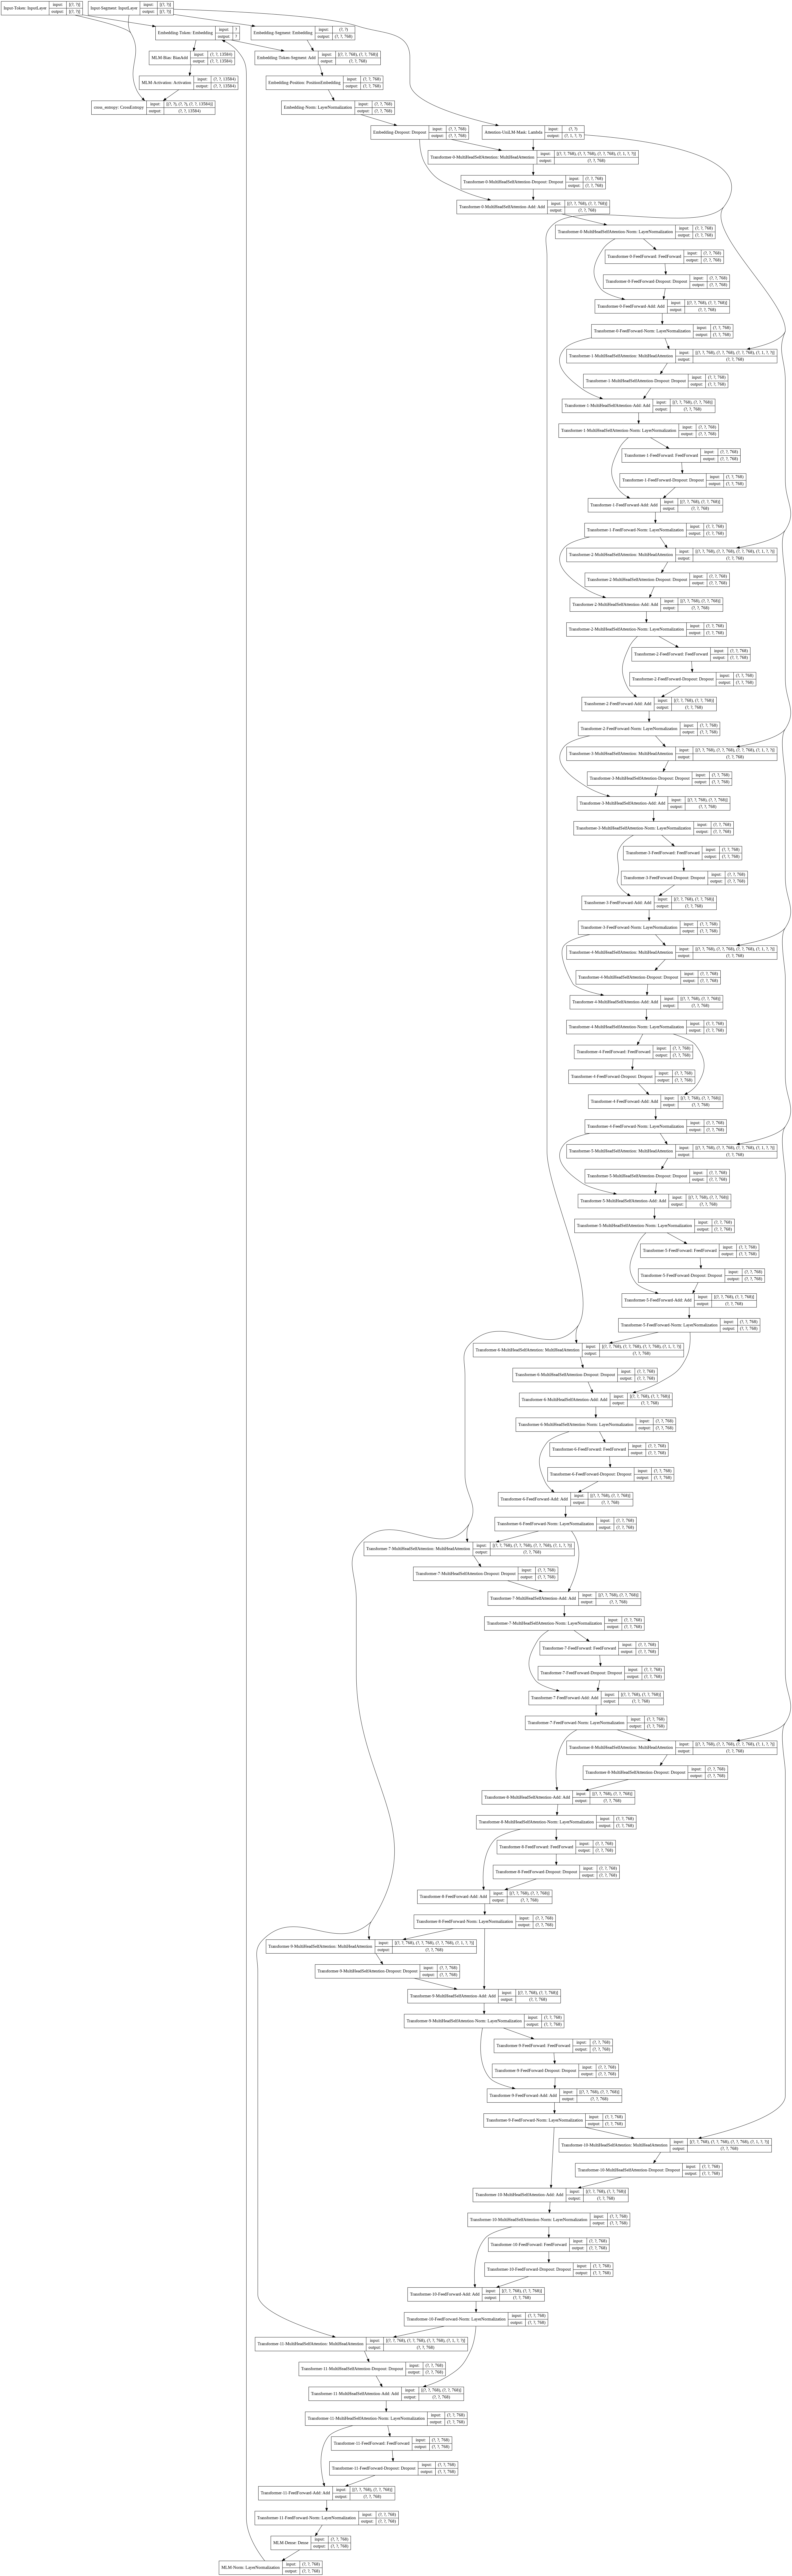

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)